In [ ]:
!pip install torch transformers pandas matplotlib

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM
import pandas as pd



In [9]:
class LogInferenceDataset(Dataset):
    def __init__(self, logs, tokenizer, max_length=128, mask_prob=0.15):
        """
        Dataset for masked language modeling (MLM) inference with BERT.
        
        Args:
        logs (list of str): List of log messages.
        tokenizer (BertTokenizer): BERT tokenizer.
        max_length (int): Maximum sequence length.
        mask_prob (float): Probability of masking a token during inference.
        """
        self.logs = logs
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.logs)

    def __getitem__(self, idx):
        log = self.logs[idx]
        inputs = self.tokenizer.encode_plus(
            log,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        # Create labels and mask some tokens
        labels = input_ids.clone()
        mask = torch.rand(input_ids.shape).lt(self.mask_prob) * (input_ids != self.tokenizer.cls_token_id) * \
               (input_ids != self.tokenizer.sep_token_id) * (input_ids != self.tokenizer.pad_token_id)
        input_ids[mask] = self.tokenizer.mask_token_id  # Replace tokens with [MASK]

        return input_ids, attention_mask, labels, mask


In [10]:
model_path = 'fine_tuned_bert_anomaly_detection'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)


In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    print("MPS device is not available. Using CPU.")
    device = torch.device("cpu")

model.to(device)
model.eval()

criterion = torch.nn.CrossEntropyLoss()


MPS device is available.


In [12]:
# Load anomalies from the CSV file
anomalies_file = 'loki_logs_last_hour_anomalies.csv'
anomalies_df = pd.read_csv(anomalies_file)
anomalies_logs = anomalies_df['log'].tolist()

# Create a dataset and dataloader for inference
inference_dataset = LogInferenceDataset(anomalies_logs, tokenizer, max_length=128, mask_prob=0.15)
inference_dataloader = DataLoader(inference_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for individual loss


In [ ]:
losses = []
with torch.no_grad():
    for input_ids, attention_mask, labels, mask in inference_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction_scores = outputs.logits

        # Calculate reconstruction error only for masked tokens
        masked_labels = labels[mask]
        masked_predictions = prediction_scores[mask]

        # Calculate loss
        loss = criterion(masked_predictions.view(-1, model.config.vocab_size), masked_labels.view(-1))
        losses.append(loss.item())


In [17]:
import matplotlib.pyplot as plt
import numpy as np



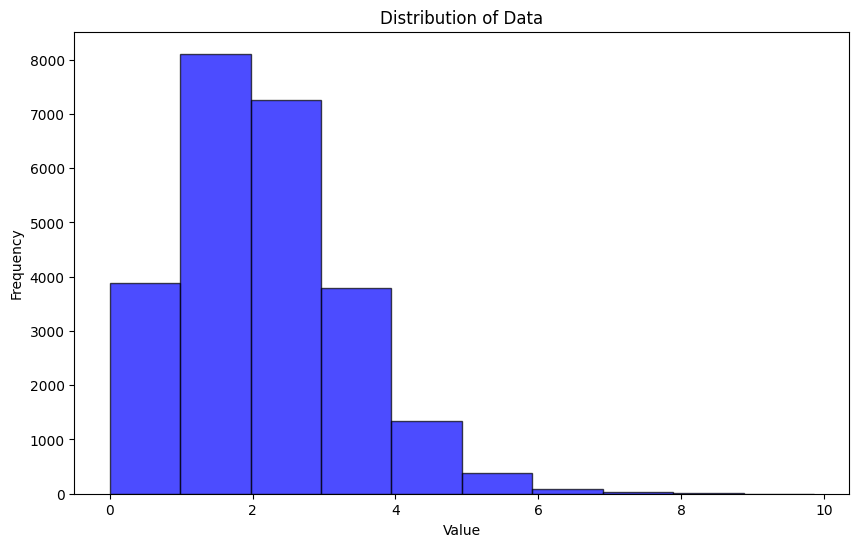

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(losses, bins=10, color='blue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Show the plot
plt.show()

In [ ]:
# Load anomalies from the CSV file
anomalies_file = 'loki_logs_last_hour_normal.csv'
anomalies_df = pd.read_csv(anomalies_file)
anomalies_logs = anomalies_df['log'].tolist()

# Create a dataset and dataloader for inference
inference_dataset = LogInferenceDataset(anomalies_logs, tokenizer, max_length=128, mask_prob=0.15)
inference_dataloader = DataLoader(inference_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for individual loss

losses = []
with torch.no_grad():
    for input_ids, attention_mask, labels, mask in inference_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction_scores = outputs.logits

        # Calculate reconstruction error only for masked tokens
        masked_labels = labels[mask]
        masked_predictions = prediction_scores[mask]

        # Calculate loss
        loss = criterion(masked_predictions.view(-1, model.config.vocab_size), masked_labels.view(-1))
        losses.append(loss.item())

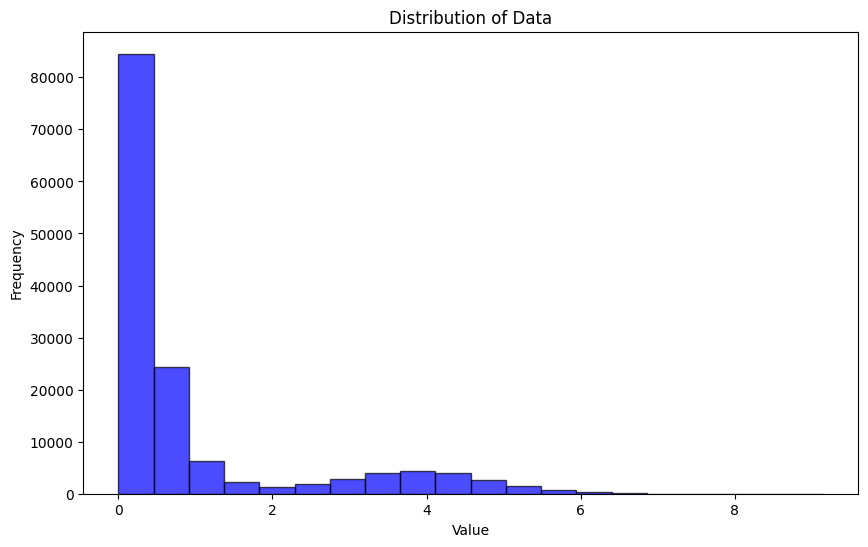

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(losses, bins=20, color='blue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Show the plot
plt.show()